[005 GSP832 Pub/Sub Lite: Qwik Start](https://www.cloudskillsboost.google/focuses/15940?catalog_rank=%7B%22rank%22%3A9%2C%22num_filters%22%3A0%2C%22has_search%22%3Atrue%7D&parent=catalog&search_id=22545949)

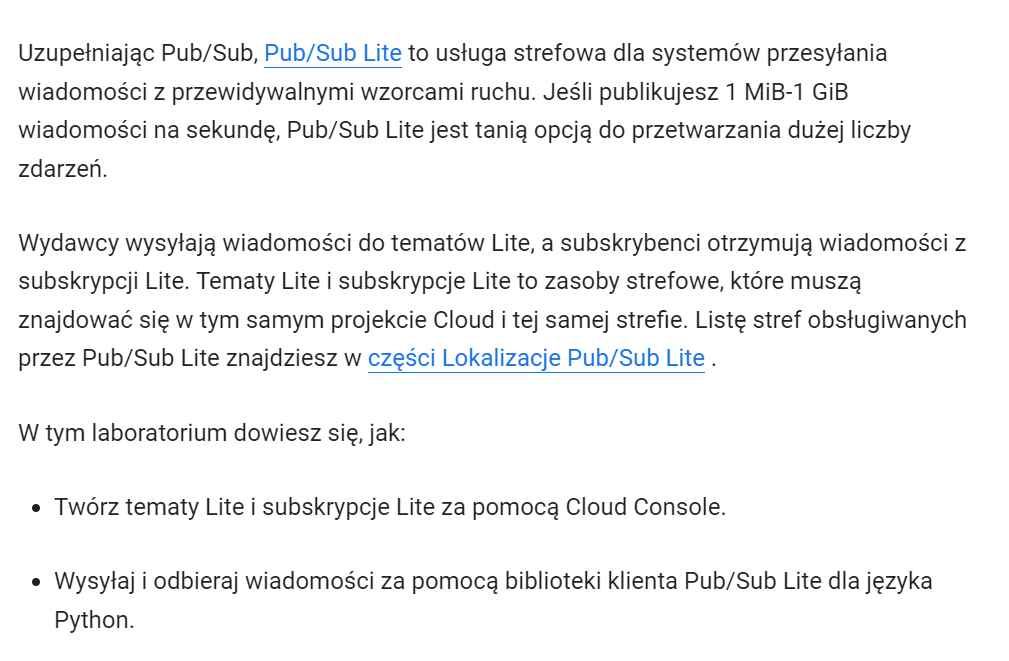

In [ ]:
# https://cloud.google.com/pubsub/docs/choosing-pubsub-or-lite
# https://cloud.google.com/pubsub/lite/docs/locations

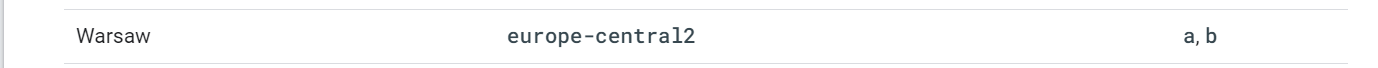

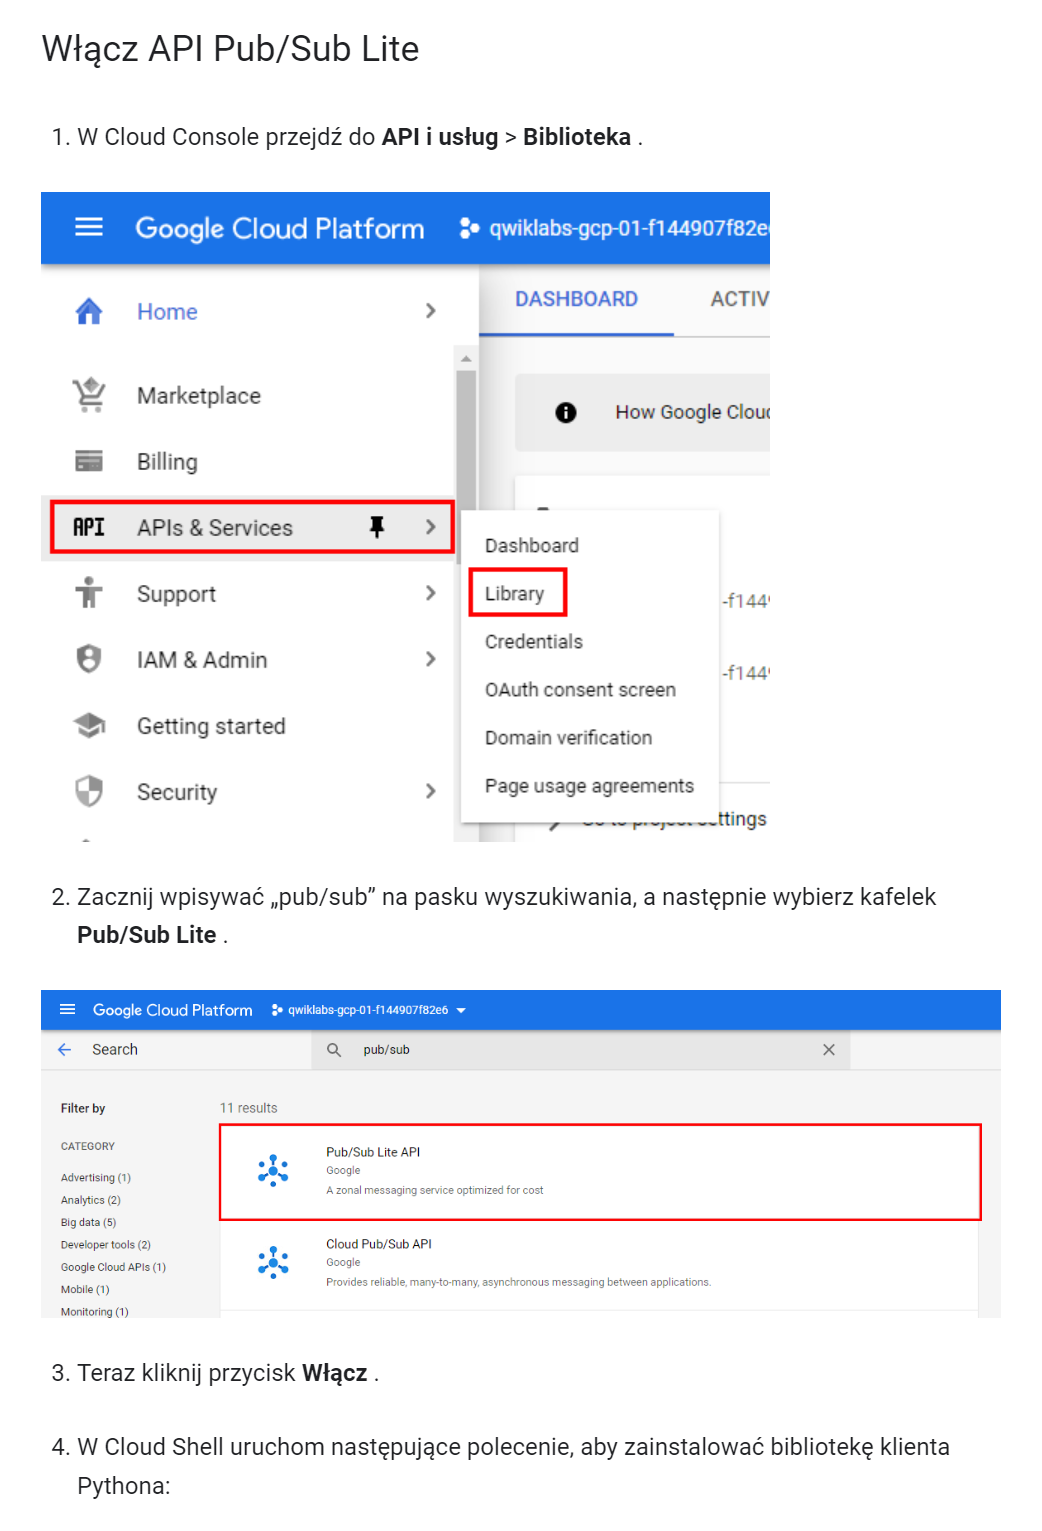

In [ ]:
pip3 install --upgrade google-cloud-pubsublite

##Zadanie 1. Utwórz temat Lite

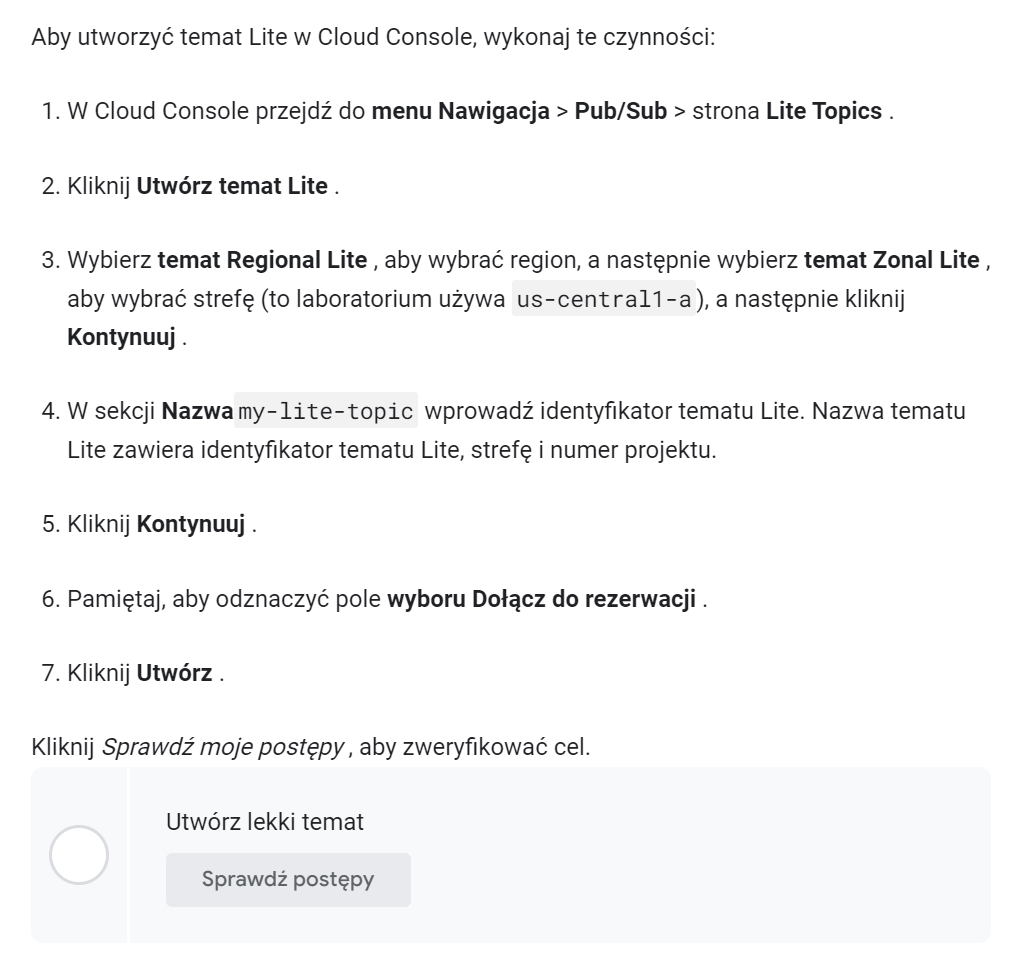

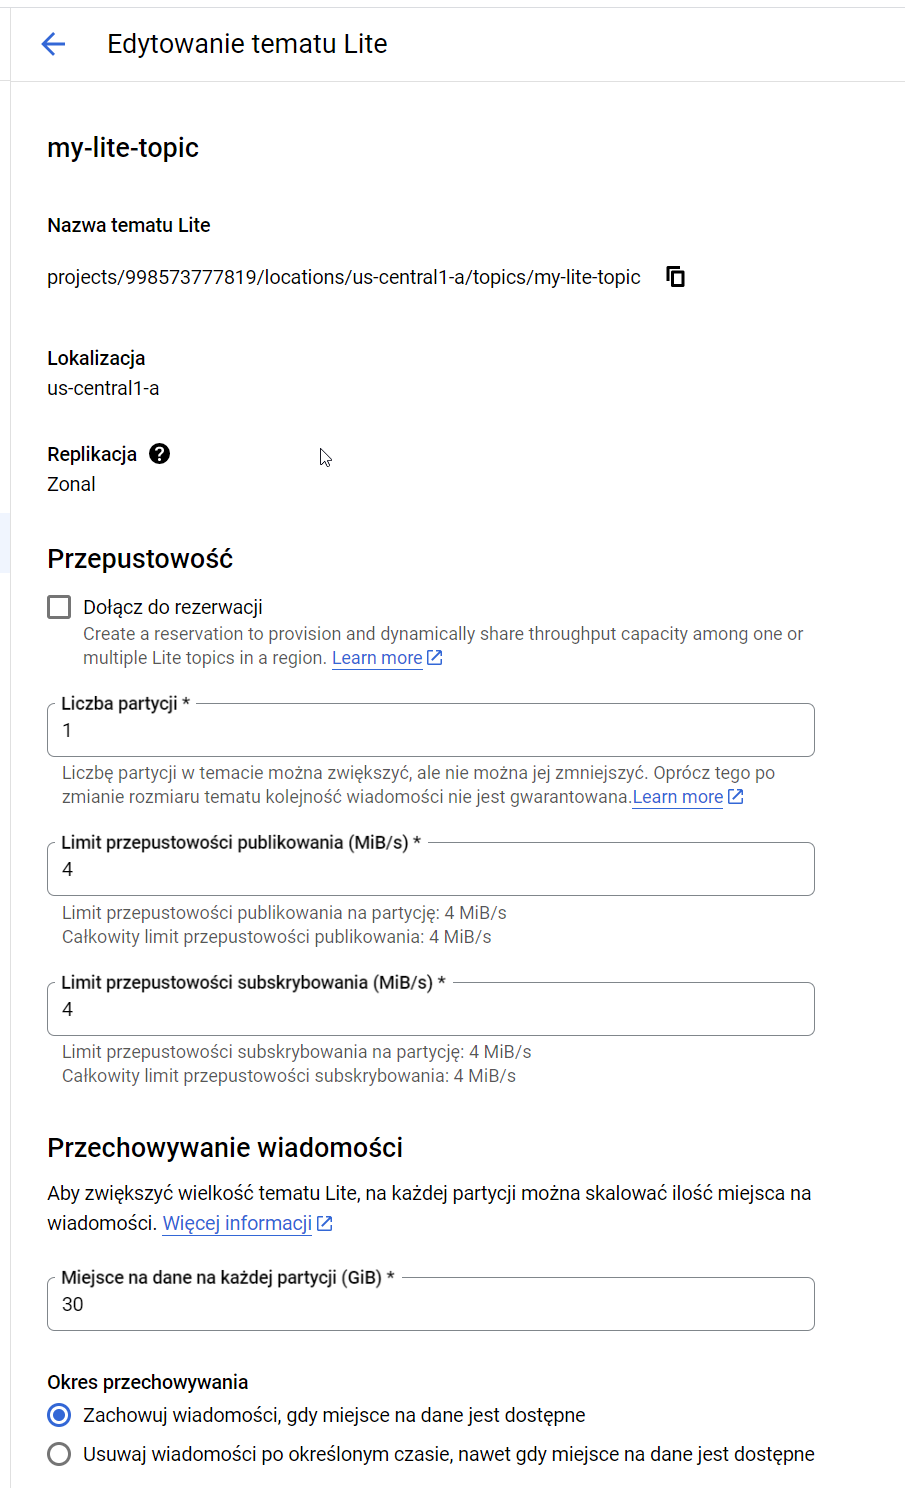

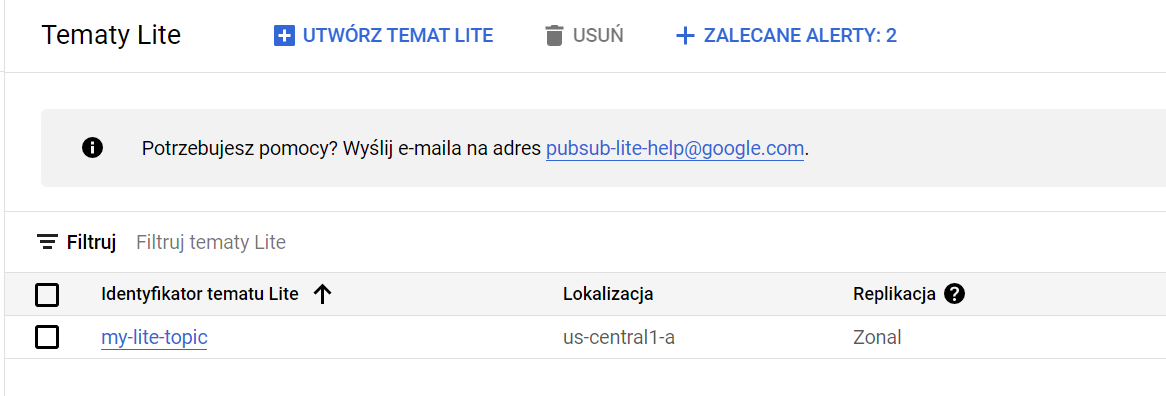

##Zadanie 2. Utwórz subskrypcję Lite

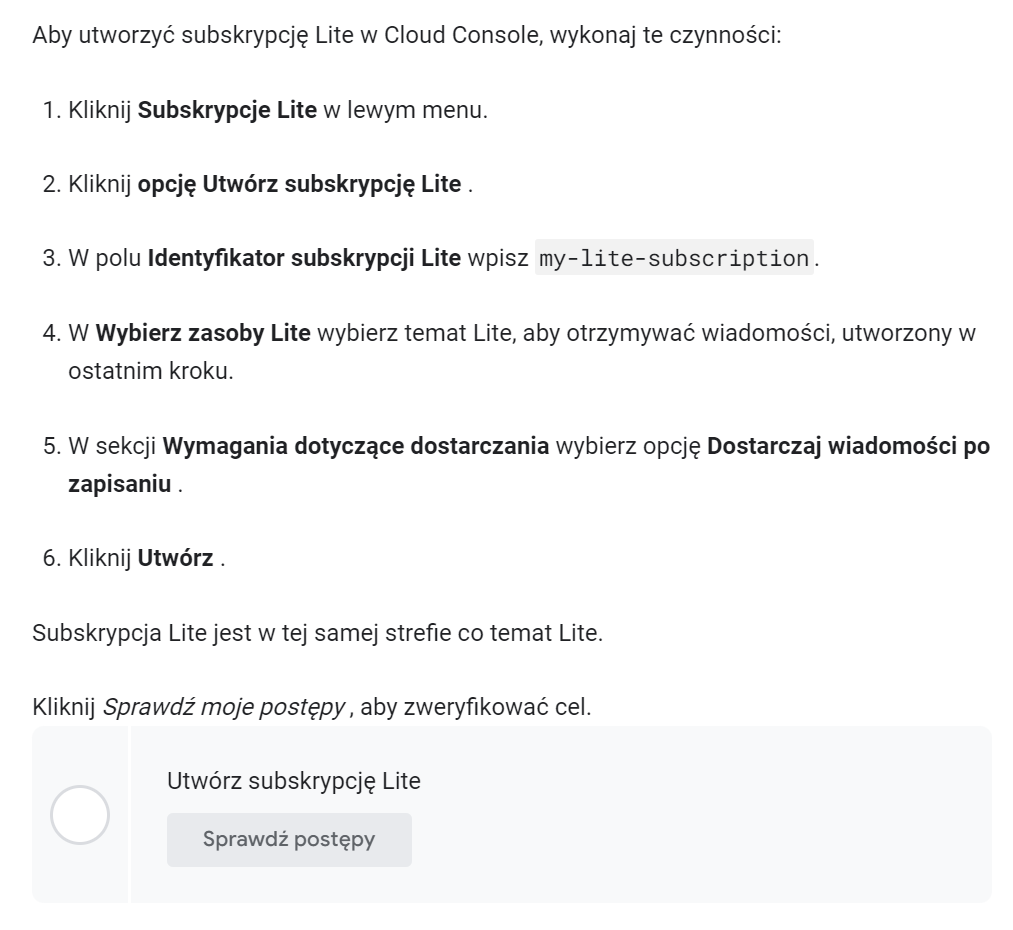

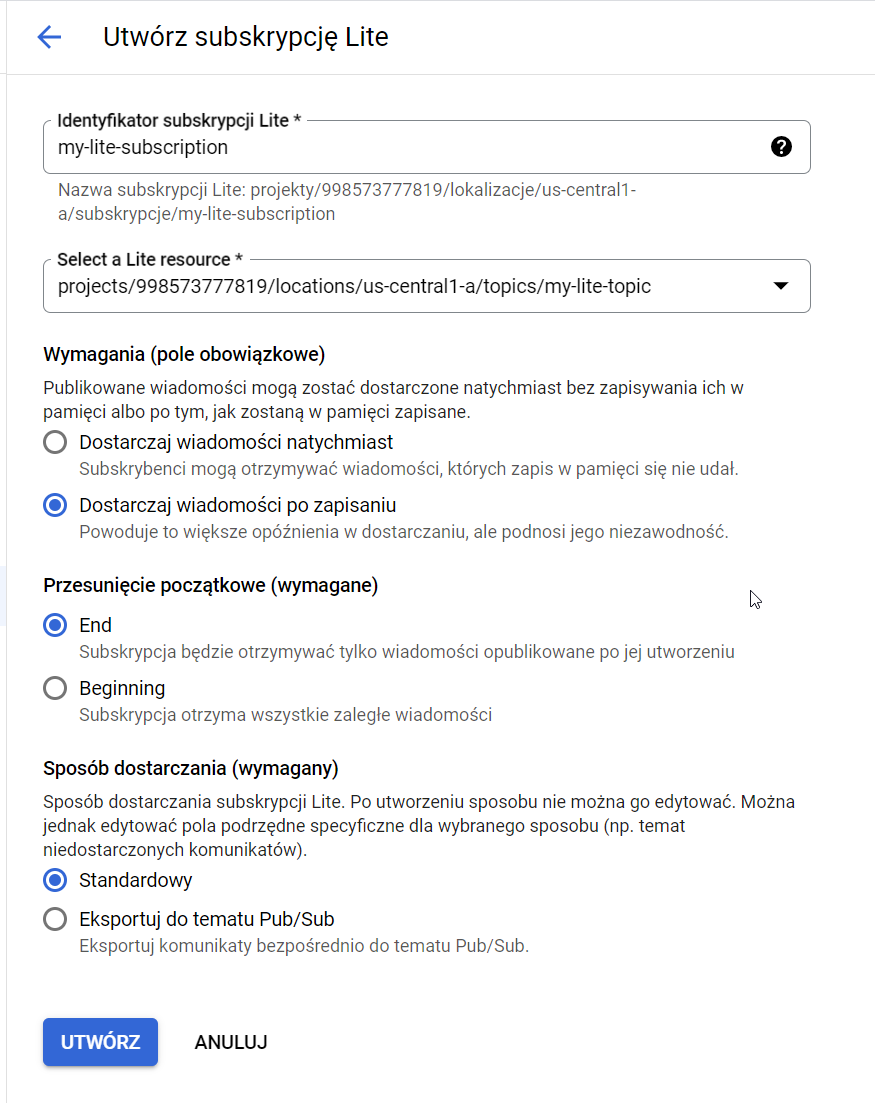

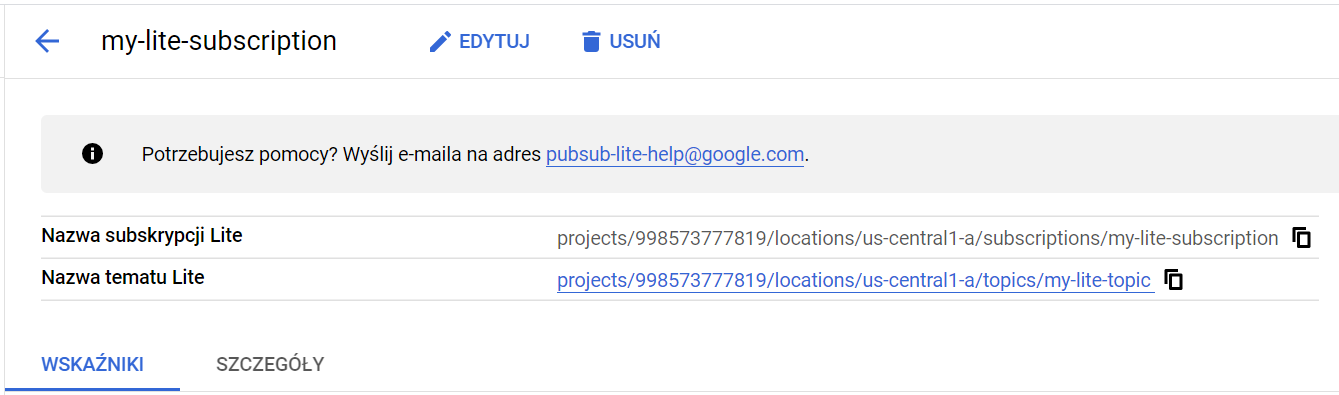

##Zadanie 3. Wysyłaj wiadomości

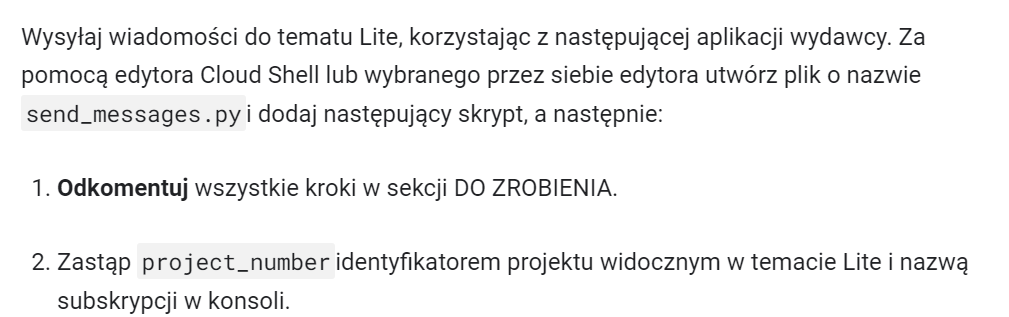

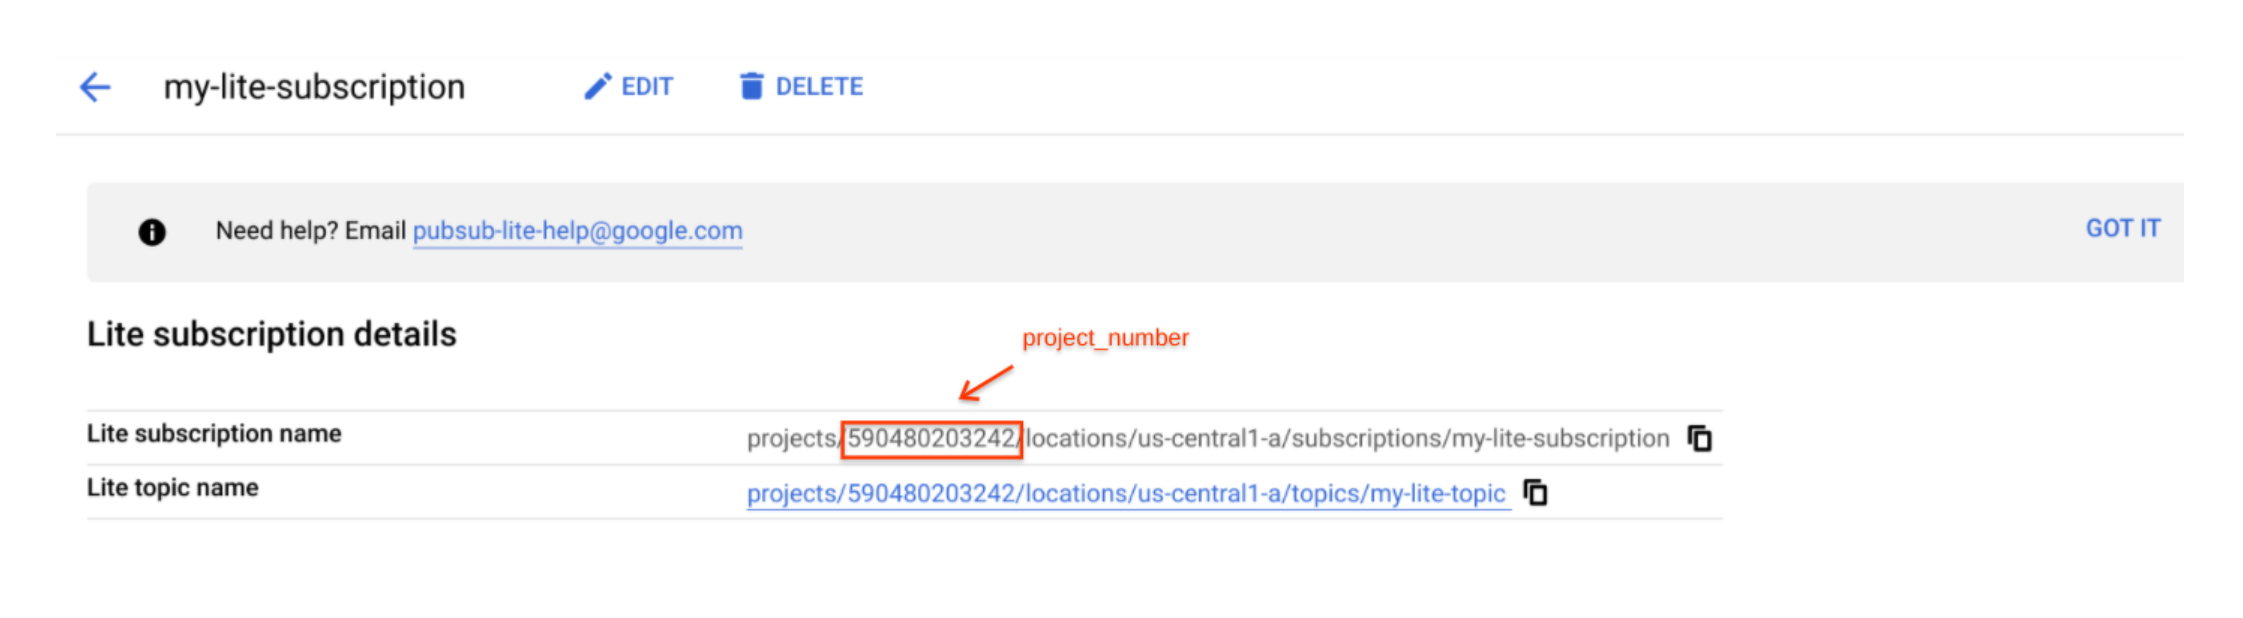

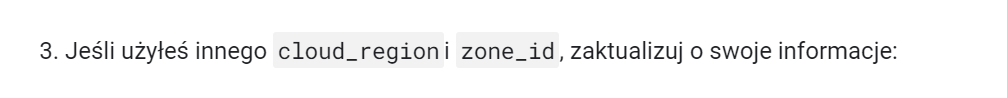

###`send_messages.py`

In [ ]:
"""Importowanie niezbędnych modułów: Importowane są moduły niezbędne do pracy z Pub/Sub Lite."""
from google.cloud.pubsublite.cloudpubsub import PublisherClient
from google.cloud.pubsublite.types import (
    CloudRegion,
    CloudZone,
    MessageMetadata,
    TopicPath,
)

"""Ustawiasz numer projektu, region chmury, identyfikator strefy, identyfikator tematu oraz liczbę wiadomości.
Te parametry są używane do określenia ścieżki tematu, do którego będą wysyłane wiadomości."""
project_number = 1122334455
cloud_region = "us-central1"
zone_id = "a"
topic_id = "my-lite-topic"
num_messages = 100

location = CloudZone(CloudRegion(cloud_region), zone_id)
# Tworzona jest ścieżka tematu (TopicPath) na podstawie podanych parametrów.
topic_path = TopicPath(project_number, location, topic_id)

"""Rozpoczęcie bloku with z PublisherClient: Tworzy się instancję PublisherClient w kontekście menedżera zasobów
(używanie with), co zapewnia poprawne zarządzanie zasobami i zamknięcie klienta po zakończeniu bloku."""
with PublisherClient() as publisher_client:

    # Tekst "Hello world!" jest przekształcany do formatu bajtów, co jest wymagane przez interfejs Pub/Sub.
    data = "Hello world!"

    """Metoda publish klienta jest używana do wysłania zakodowanej wiadomości do określonego tematu.
    Zwraca ona obiekt api_future, który można użyć do śledzenia statusu operacji wysyłania."""
    api_future = publisher_client.publish(topic_path, data.encode("utf-8"))

    """Metoda result jest wywoływana na api_future, aby poczekać na zakończenie wysyłania wiadomości
    i otrzymać identyfikator wiadomości"""
    message_id = api_future.result()

    """Dekoduje identyfikator wiadomości, aby uzyskać metadane, w tym informacje o partycji i przesunięciu,
    gdzie wiadomość została zapisana."""
    publish_metadata = MessageMetadata.decode(message_id)
    print(
        f"Published a message to partition {publish_metadata.partition.value} and offset {publish_metadata.cursor.offset}."
    )

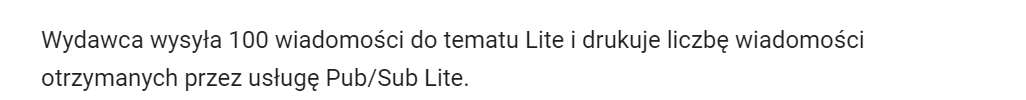

##Zadanie 4. Odbieraj wiadomości

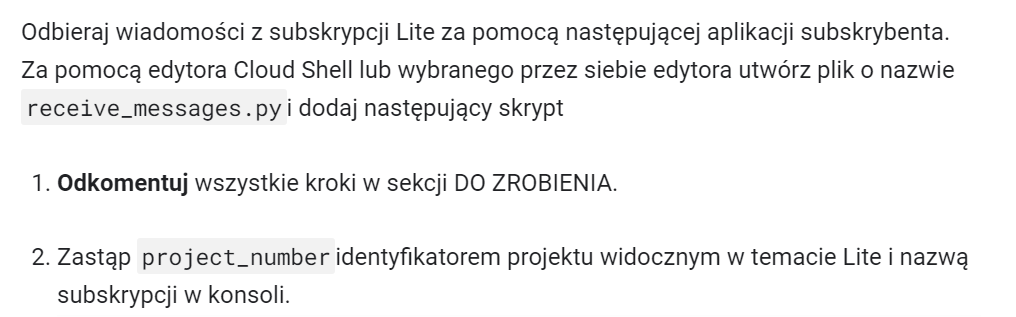

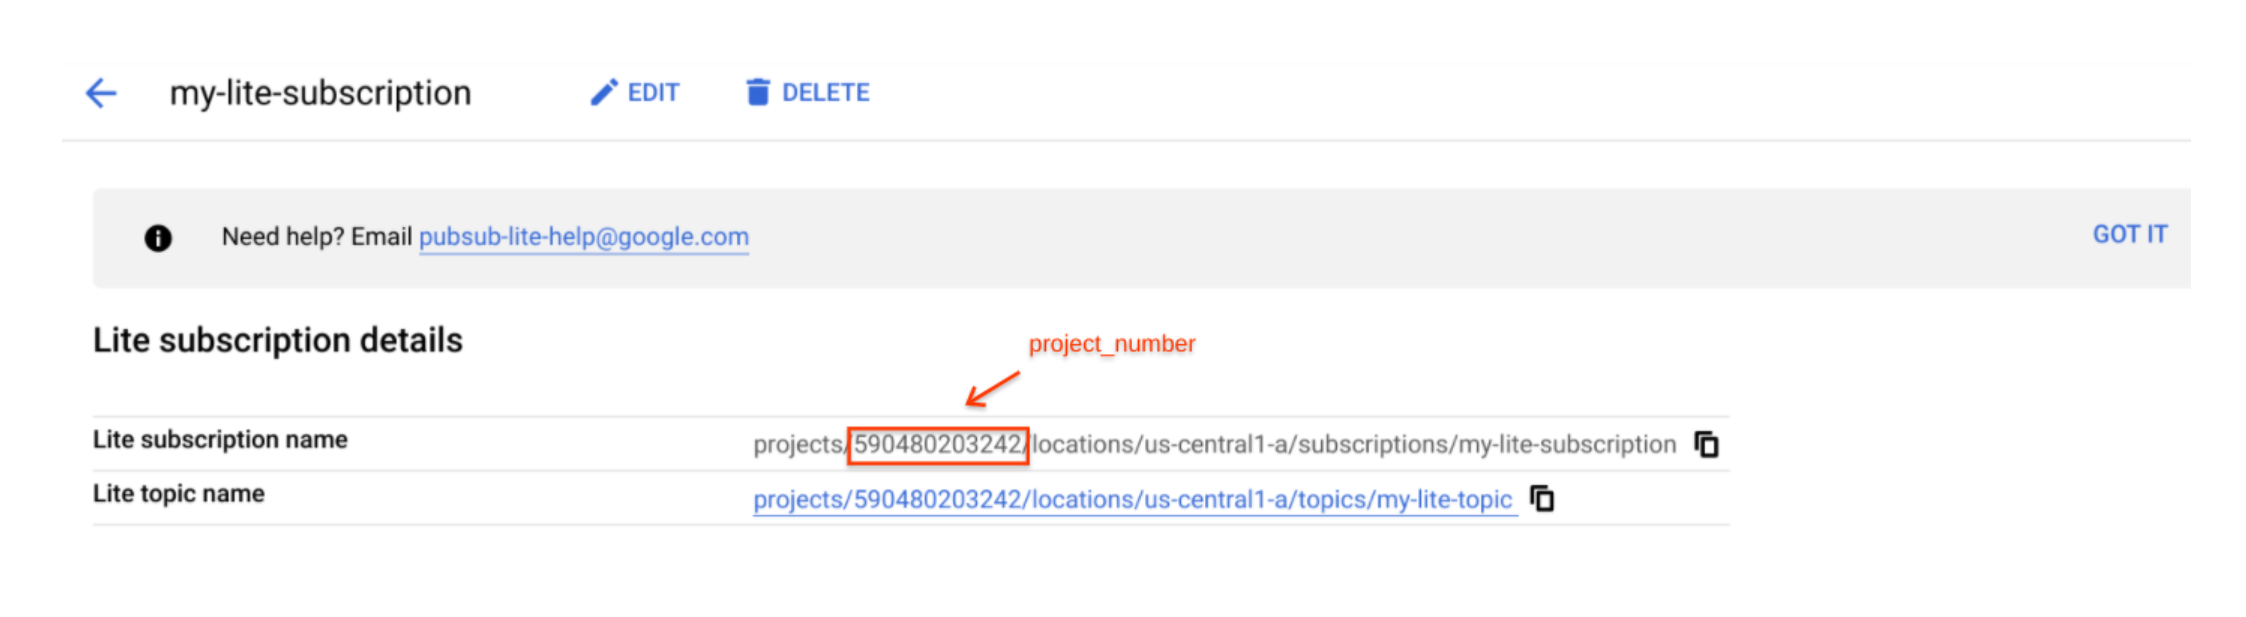

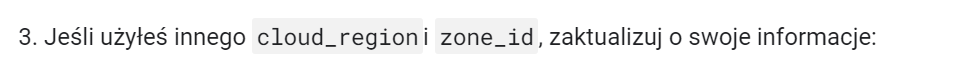

###`receive_messages.py`

In [ ]:
"""Importowanie niezbędnych modułów:
SubscriberClient z google.cloud.pubsublite.cloudpubsub jest używany do tworzenia subskrybenta.
CloudRegion, CloudZone, FlowControlSettings, i SubscriptionPath są używane do konfigurowania subskrypcji
oraz jej ustawień."""

from concurrent.futures._base import TimeoutError
from google.cloud.pubsublite.cloudpubsub import SubscriberClient
from google.cloud.pubsublite.types import (
    CloudRegion,
    CloudZone,
    FlowControlSettings,
    SubscriptionPath,
)

project_number = 1122334455
cloud_region = "us-central1"
zone_id = "a"
subscription_id = "my-lite-subscription"
timeout = 90

# Utworzenie obiektu CloudZone oraz SubscriptionPath reprezentujących lokalizację subskrypcji.
location = CloudZone(CloudRegion(cloud_region), zone_id)
subscription_path = SubscriptionPath(project_number, location, subscription_id)

"""Konfiguracja ustawień przepływu (per_partition_flow_control_settings) określających, kiedy subskrybent ma
wstrzymać odbieranie wiadomości na podstawie rozmiaru wiadomości."""
per_partition_flow_control_settings = FlowControlSettings(
    messages_outstanding=1000,
    bytes_outstanding=10 * 1024 * 1024, # co oznacza 10 megabajtów (10 MB)
)

"""Definicja funkcji callback, która zostanie wywołana po odbiorze wiadomości. Funkcja dekoduje dane z wiadomości,
wyświetla je i potwierdza odbiór wiadomości (message.ack())."""
def callback(message):
    message_data = message.data.decode("utf-8")
    print(f"Received {message_data} of ordering key {message.ordering_key}.")
    message.ack()

"""Utworzenie obiektu SubscriberClient w bloku with. Ten obiekt zostanie automatycznie zamknięty po zakończeniu pracy.
Wywołanie subscriber_client.subscribe() w celu rozpoczęcia subskrypcji. Określa się tutaj ścieżkę subskrypcji,
funkcję callback oraz ustawienia przepływu wiadomości."""
with SubscriberClient() as subscriber_client:
    streaming_pull_future = subscriber_client.subscribe(
        subscription_path,
        callback=callback,
        per_partition_flow_control_settings=per_partition_flow_control_settings,
    )
    print(f"Listening for messages on {str(subscription_path)}...")
    try:

        """Rozpoczęcie odbierania wiadomości poprzez wywołanie streaming_pull_future.result(timeout=timeout).
        Kod będzie nasłuchiwał na nowe wiadomości i wywoływał funkcję callback dla każdej odebranej wiadomości."""
        streaming_pull_future.result(timeout=timeout)
    except TimeoutError or KeyboardInterrupt:
        streaming_pull_future.cancel()
        assert streaming_pull_future.done()

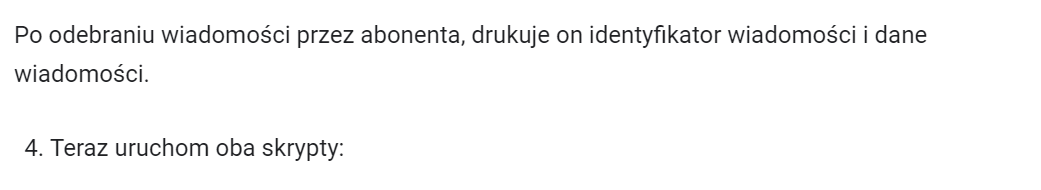

In [ ]:
python3 send_messages.py

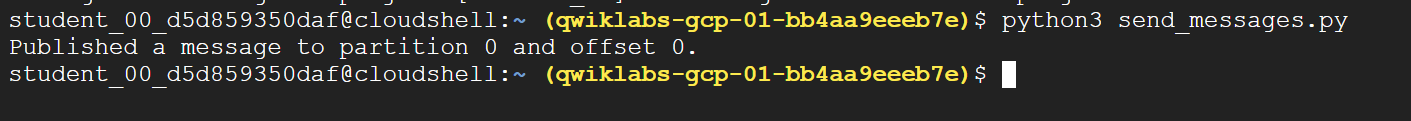

In [ ]:
python3 receive_messages.py

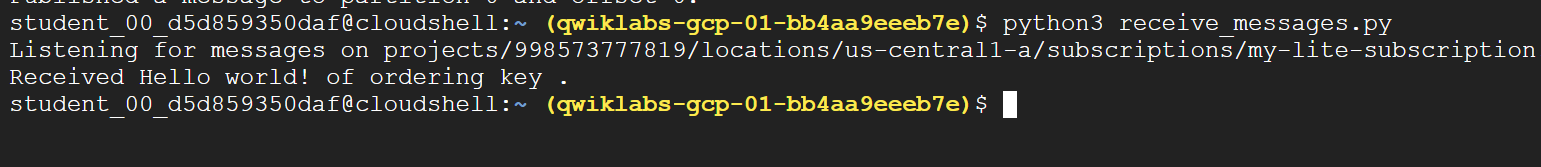

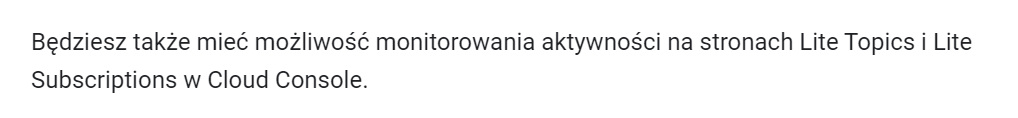

##Zadanie 5. Posprzątaj

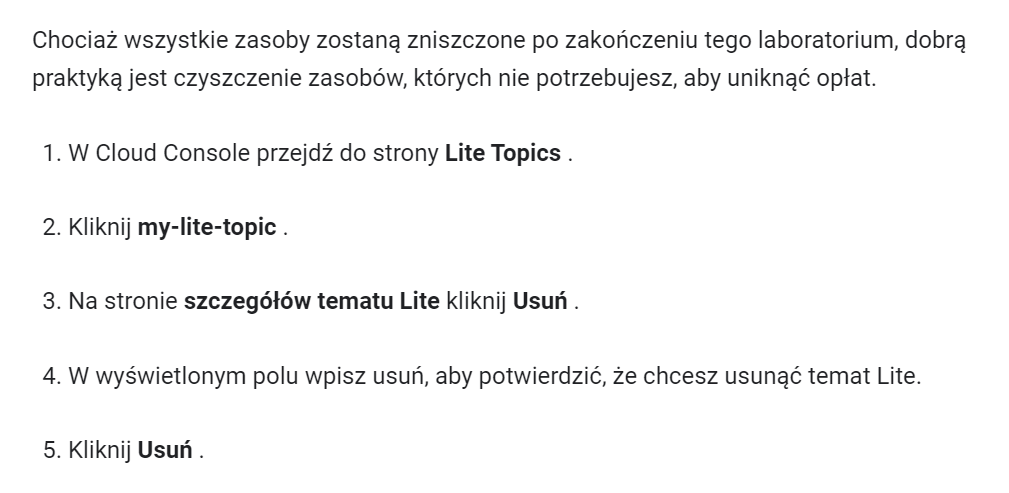

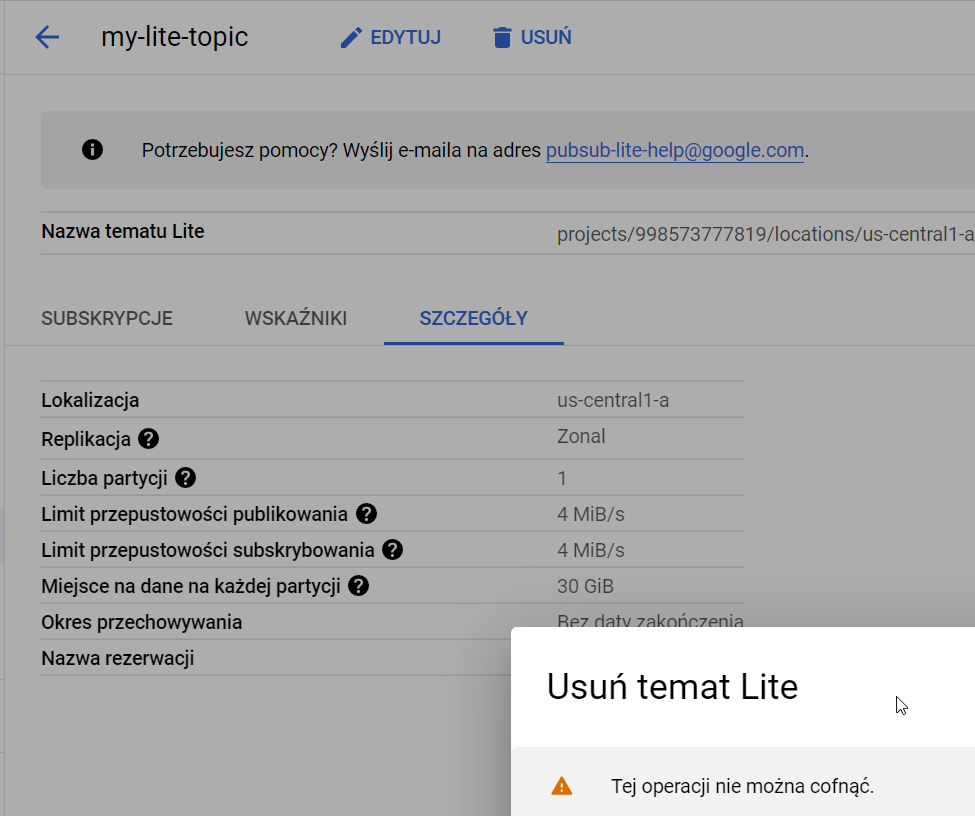